## Pytorch based U-Net++ for Fault Prediction

## System Specification


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bb7c87a7-cb98-dc1f-40ba-7b841795bc1e)


In [2]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Thu Apr 20 15:55:09 2023
Driver Version                            : 525.85.12
CUDA Version                              : 12.0

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla T4
    Product Brand                         : NVIDIA
    Product Architecture                  : Turing
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 1560321022315
    GPU UUID             

In [3]:
!nvidia-smi

Thu Apr 20 15:55:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!lscpu |grep 'Model name'

Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz


In [5]:
!free -h --si | awk  '/Mem:/{print $2}'

12G


In [6]:

!pip install segyio
from matplotlib import pyplot as plt #importing plotly library for plots
import numpy as np #importing numpy library for arrays
import segyio #importing segyio library to analyse segy image files of seismic image volume data

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 7.2 MB/s eta 0:00:00


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Set the value of the variable `pp_file` to the string "issap20_Pp.sgy"
pp_file = "/content/drive/MyDrive/Colab Notebooks/issap20_Pp.sgy"

# Set the value of the variable `ai_file` to the string "issap20_AI.sgy"
ai_file = "/content/drive/MyDrive/Colab Notebooks/issap20_AI.sgy"

# Set the value of the variable `fault_file` to the string "issap20_Fault.sgy"
fault_file = "/content/drive/MyDrive/Colab Notebooks/issap20_Fault.sgy"

In [9]:
# Load slb synthetics
slb_isFault_filepath = "Schlumberger_800_SLB_Force_Fault_Model_IsFault.segy"

In [10]:
# Define a function called `segyTonumpy` that takes a string argument `filename`
# and returns a numpy array. The function uses the `segyio` library to open the
# file specified by `filename` and extract the data as a 3D cube, which is then
# returned as a numpy array.
def segyTonumpy(filename: str) -> np.ndarray:
    # Open the SEG-Y file specified by `filename` and set the `xline` parameter to 181.
    segy_file = segyio.open(filename, xline=181)
    try:
        # Use the `cube` function from the `segyio.tools` module to extract the data
        # from the SEG-Y file as a 3D cube, which is stored in the `sies_data` variable.
        sies_data = segyio.tools.cube(segy_file)
    finally:
        # Make sure to close the SEG-Y file when done to free up resources.
        segy_file.close()
    
    # Return the 3D cube as a numpy array.
    return sies_data

# Call the `segyTonumpy` function for each of the three SEG-Y files and store the results
# in variables named `seismic_img_arr`, `ai_img_arr`, and `fault_img_arr`, respectively.
seismic_img_arr = segyTonumpy(pp_file)
ai_img_arr = segyTonumpy(ai_file)
fault_img_arr = segyTonumpy(fault_file)

In [11]:
# Print the type of the `seismic_img_arr` variable, which should be a numpy array.
print(type(seismic_img_arr))

# Print the type of the `ai_img_arr` variable, which should be a numpy array.
print(type(ai_img_arr))

# Print the type of the `fault_img_arr` variable, which should be a numpy array.
print(type(fault_img_arr))

# Print the shape of the `fault_img_arr` numpy array, which should be a tuple containing the
# dimensions of the array (e.g., (100, 100, 50)).
print(fault_img_arr.shape)

# Print the unique values in the `fault_img_arr` numpy array, which should give us an idea of
# the range of values in the array.
print(np.unique(fault_img_arr))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(101, 589, 751)
[0. 1.]


In [12]:
#display the dimensions of the seismic dataset
"Number of inlines: %d, crosslines: %d, samples: %d" % (seismic_img_arr.shape[0], seismic_img_arr.shape[1], seismic_img_arr.shape[2])

'Number of inlines: 101, crosslines: 589, samples: 751'

In [13]:
def plot(synth, ai, fault, line_type, line_num):
    """
    Plot a slice of synthetic seismic and AI data with an overlaid fault slice.

    Args:
    synth (numpy.ndarray): The synthetic seismic data array.
    ai (numpy.ndarray): The AI data array.
    fault (numpy.ndarray): The fault data array.
    line_type (str): Either 'xline' or 'inline' depending on which type of seismic line to plot.
    line_num (int): The line number to plot.

    Returns:
    None
    """

    # Create a slice for the specified seismic line.
    line_num_slice = (slice(None),) + (line_num,) * (line_type == 'xline') + (line_num, ) * (line_type == 'inline')

    # Extract the seismic, AI, and fault data for the specified line.
    synth_slice = synth[line_num_slice].T
    ai_slice = ai[line_num_slice].T
    fault_slice = fault[line_num_slice].T

    # Create a figure with two subplots for the seismic and AI data.
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

    # Set the titles and colormaps for the subplots.
    titles = ['Synthetic Seismic Data Image', 'AI Data Image']
    cmaps = ["seismic", None]

    # Print a message indicating which seismic line is being plotted.
    print(f'\nPlotting {line_type.upper()} {line_num}')

    # Plot the seismic and AI data with an overlaid fault slice.
    for ax, title, cmap, data in zip(axes, titles, cmaps, [synth_slice, ai_slice]):
        ax.set_title(title)
        ax.imshow(data, cmap=cmap, extent=[0, data.shape[1], data.shape[0], 0])
        ax.imshow(fault_slice, cmap='Greys', vmin=0, vmax=1, alpha=0.3, extent=[0, data.shape[1], data.shape[0], 0])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # Show the plot.
    plt.show()


Plotting INLINE 20


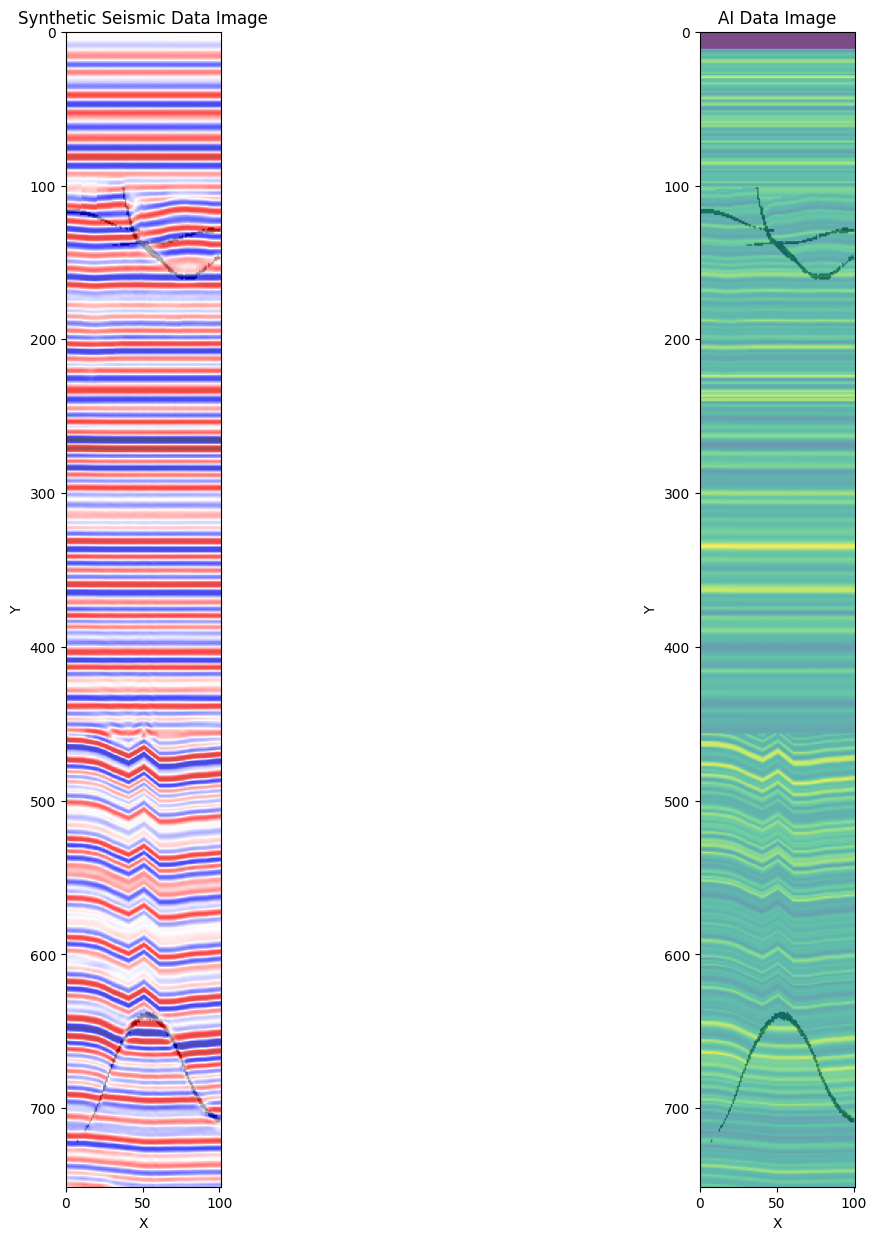

In [14]:
plot(seismic_img_arr, ai_img_arr, fault_img_arr, line_type='inline', line_num=20)


Plotting XLINE 120


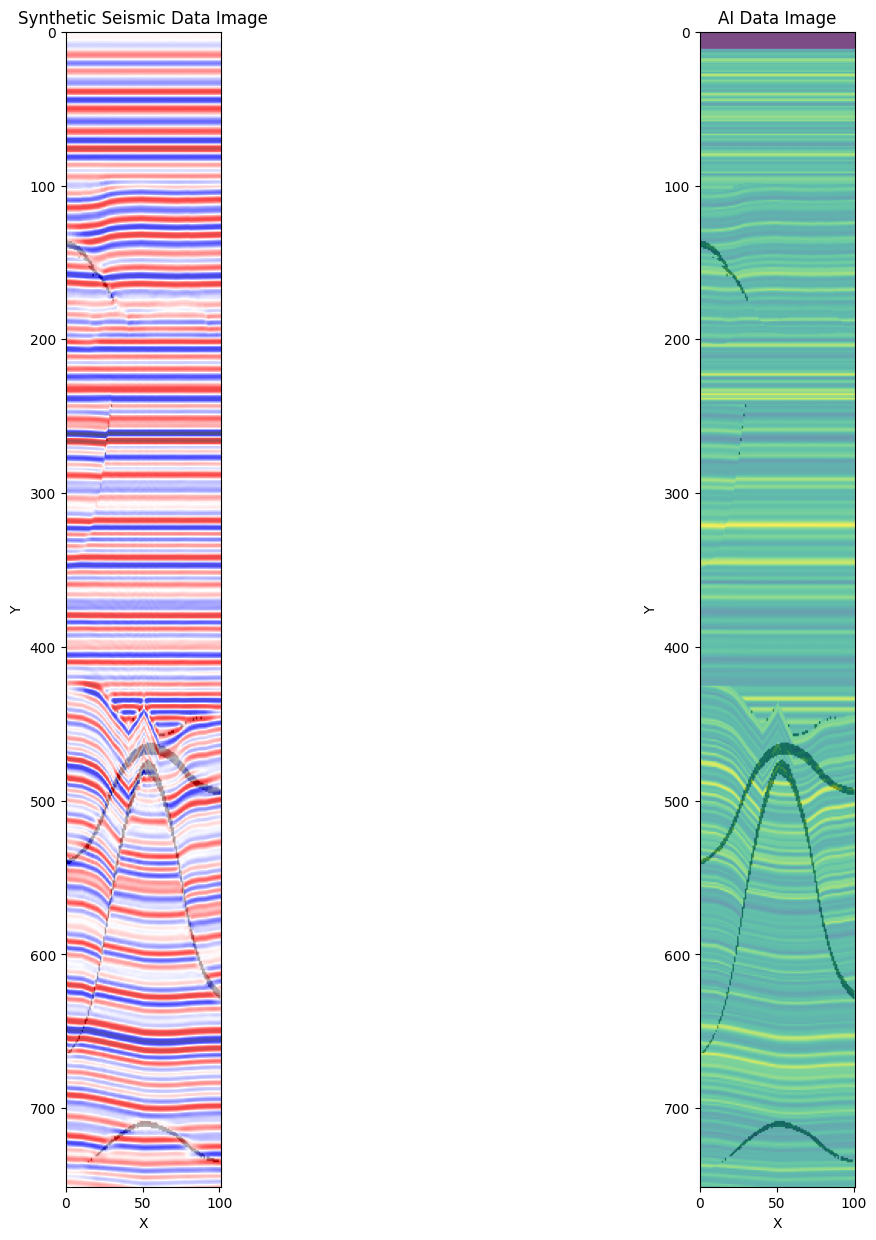

In [15]:
plot(seismic_img_arr, ai_img_arr, fault_img_arr, line_type='xline', line_num=120)

In [16]:
from ipywidgets import widgets

In [19]:
# Create an output widget for the plot
plot_output = widgets.Output()

# Create a button widget to trigger the plot
plot_button = widgets.Button(description='View Images', tooltip='Click this button to view image plots.')

# Define a callback function to be executed when the button is clicked
@plot_button.on_click
def on_button_clicked(b):
    with plot_output:
        # Call the plot function with the required parameters
        plot(seismic_img_arr, ai_img_arr, fault_img_arr, line_type='xline', line_num=70)
        plot_output.clear_output(wait=True)

# Create a vertical box to hold the button and the plot output
display(widgets.VBox([plot_button, plot_output]))

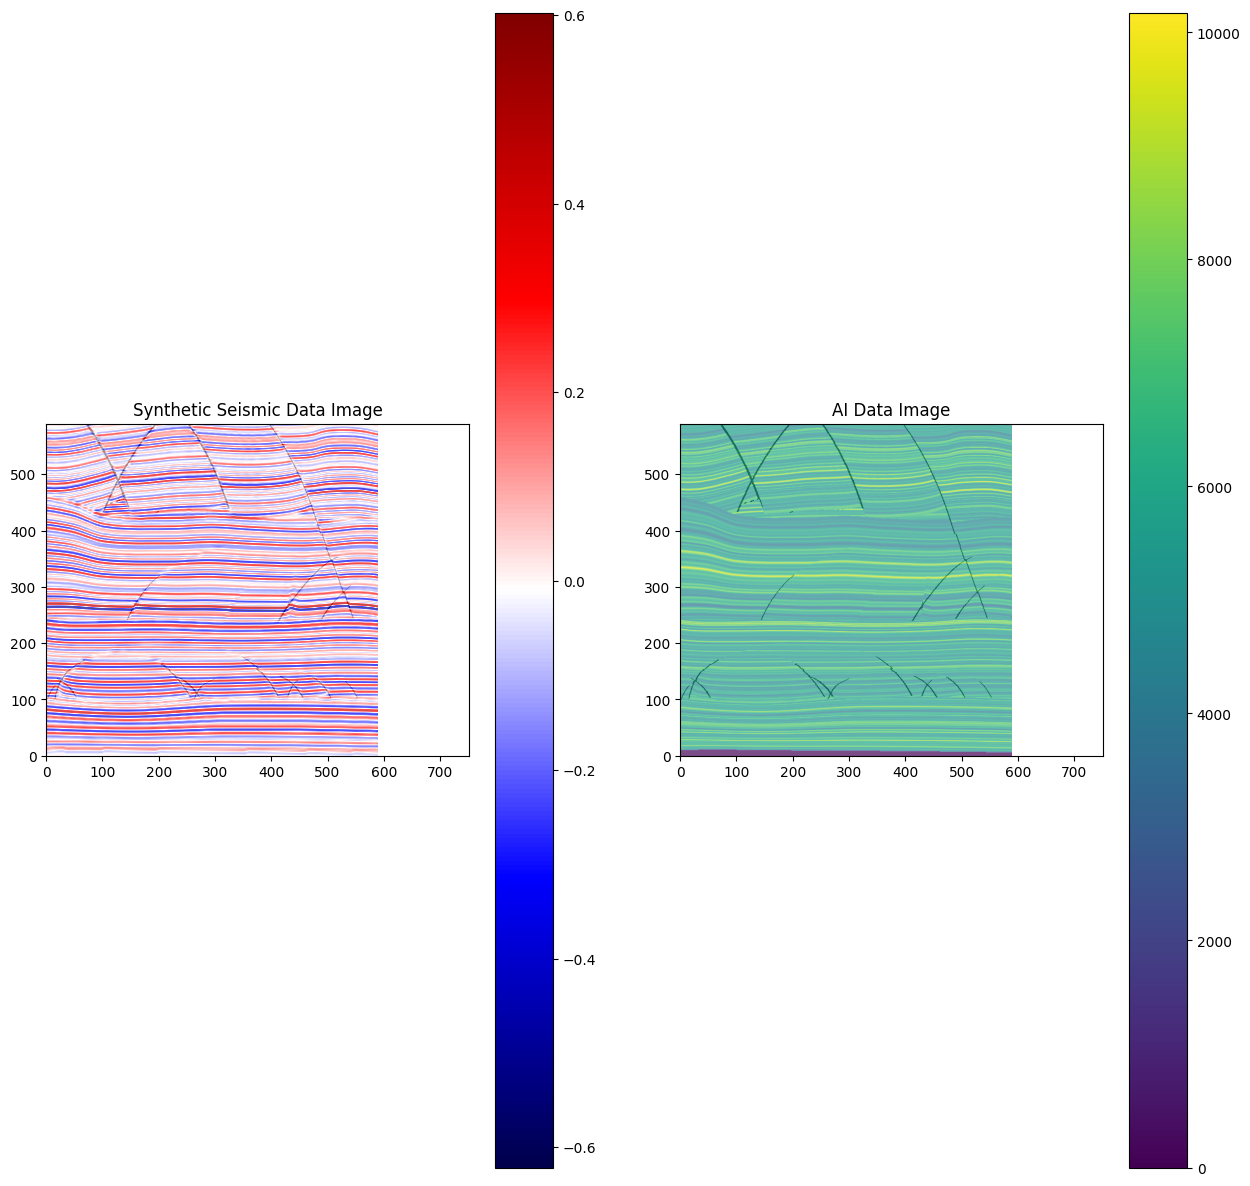

In [20]:
# Define the line number to be plotted
ILINE = 40

# Set the figure size and the title for each subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
titles = ['Synthetic Seismic Data Image', 'AI Data Image']
cmaps = ["seismic", None]

# Loop through each cube to plot
for i, cube in enumerate([seismic_img_arr, ai_img_arr]):
    # Set the title of the subplot
    axs[i].set_title(titles[i])
    
    # Plot the image with the appropriate colormap
    im = axs[i].imshow(cube[ILINE, :, :].T, cmap=cmaps[i])
    
    # Plot the fault on top of the image
    axs[i].imshow(fault_img_arr[ILINE, :, :].T, cmap='Greys', vmin=0, vmax=1, alpha=0.3)
    
    # Set the x and y limits to match the image dimensions
    axs[i].set_xlim([0, cube.shape[2]])
    axs[i].set_ylim([0, cube.shape[1]])
    
    # Add a colorbar to the image
    cbar = fig.colorbar(im, ax=axs[i])
    
# Display the figure
plt.show()

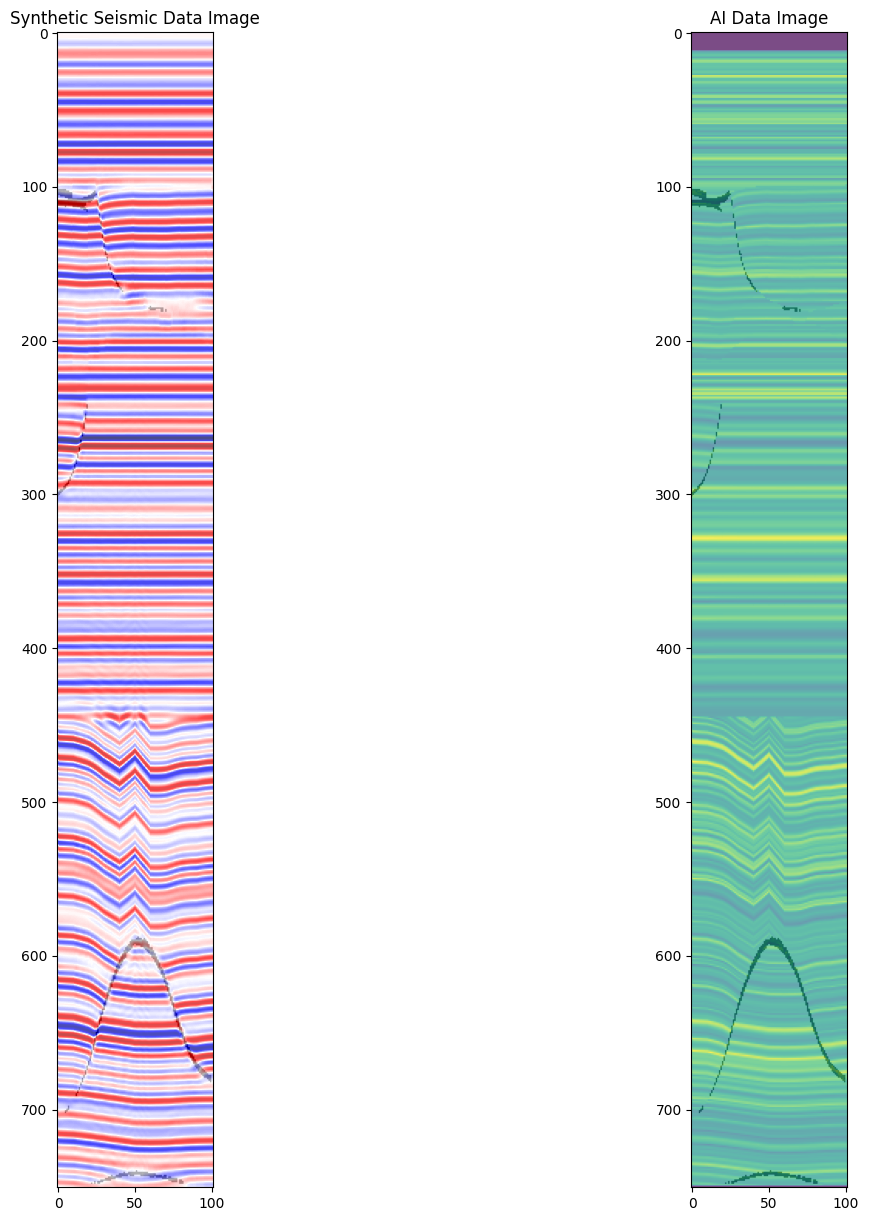

In [21]:
# Function definition
def plot_crossline(cube_list, fault, xline, titles, cmaps):
    # Create a figure with subplots using the number of elements in cube_list
    fig, axs = plt.subplots(1, len(cube_list), figsize=(15, 15))
    
    # Loop over the cube_list and add a subplot with a title and an image
    for i, cube in enumerate(cube_list):
        axs[i].set_title(titles[i])
        im = axs[i].imshow(cube[:, xline, :].T, cmap=cmaps[i])
        
        # Add a second image on top of the previous one with transparency 
        # (alpha) set to 0.3 and the gray colormap (Greys)
        axs[i].imshow(fault[:, xline, :].T, cmap='Greys', vmin=0, vmax=1, alpha=0.3)
        
        # Set the axis limits
        axs[i].axis()
    
    # Show the plot
    plt.show()


# Define variables
xline = 60
titles = ['Synthetic Seismic Data Image', 'AI Data Image']
cmaps = ["seismic", None]

# Call the function
plot_crossline([seismic_img_arr, ai_img_arr], fault_img_arr, xline, titles, cmaps)

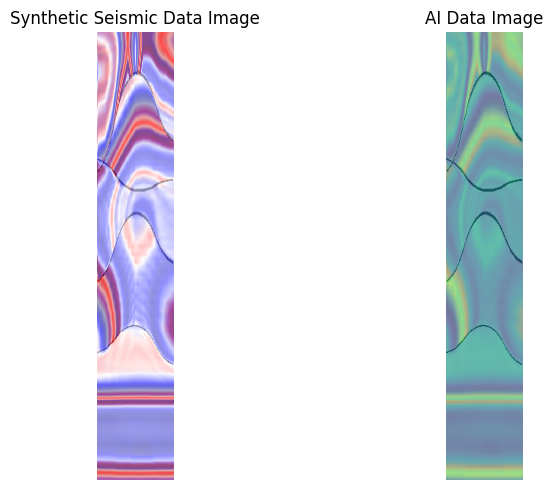

In [23]:
# Set constants
DEPTH = 600
TITLES = ['Synthetic Seismic Data Image', 'AI Data Image']
CMAPS = ['seismic', None]
NUM_SUBPLOTS = len(TITLES)

# Create figure and subplots
fig, axs = plt.subplots(1, NUM_SUBPLOTS, figsize=(10, 5))

# Plot seismic data and AI predictions with fault overlay
for i, title in enumerate(TITLES):
    axs[i].set_title(title)
    axs[i].imshow(seismic_img_arr[:, :, DEPTH].T, cmap=CMAPS[i])
    axs[i].imshow(ai_img_arr[:, :, DEPTH].T, cmap=CMAPS[i], alpha=0.5)
    axs[i].imshow(fault_img_arr[:, :, DEPTH].T, cmap='Greys', vmin=0, vmax=1, alpha=0.3)
    axs[i].axis('off')

# Display the figure
plt.tight_layout()
plt.show()

In [24]:
slb_isFault_filepath = "/content/drive/MyDrive/Colab Notebooks/Schlumberger_800_SLB_Force_Fault_Model_IsFault.segy"

fault_slb = segyTonumpy(slb_isFault_filepath)

In [25]:
# Get the shape of the fault_slb array
fault_slb_shape = fault_slb.shape

# Extract the first element of the fault_slb array and assign it to df
df_slb = fault_slb[0]

In [26]:
df_slb

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

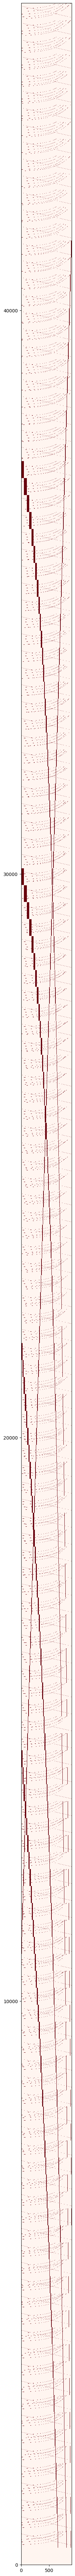

In [27]:
# Set the size of the figure
plt.figure(figsize=(100, 100))

# Display the image with the desired colormap and interpolation
plt.imshow(df_slb, cmap='Reds', interpolation='nearest', origin='lower')

# Show the plot
plt.show()

### Contracting Path
The contracting path is the encoder section of the U-Net which involves several downsampling steps.
It consists of the repeated application of two 3x3 convolutions (unpadded), each followed by a ReLU and 2x2 max pooling operation with stride of 2 for downsampling. At each downsampling step we double the number of feature channels.
Note: in the original U-Net framework, the resulting output has smaller size than the input. I am using a padding of (1,1) to make sure we get the same shape as input in Expanding block.

In [28]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        
        # Wou want to double the number of channels in the first convolution
        # and keep the same number of channels in the second.
        
        self.conv1 = nn.Conv2d(input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
       

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

In [29]:
# unit test
def test_contracting_block(test_samples = 1, test_channels=1, test_size=254):
    test_block = ContractingBlock(test_channels)
    test_in = torch.randn(test_samples, test_channels, test_size, test_size)
    test_out_conv1 = test_block.conv1(test_in)
    
    # Make sure that the first convolution has the right shape
    print(test_out_conv1.shape)
#     print(test_block.shape)

In [30]:
test_contracting_block(128)
# 1, 512, 60, 60

torch.Size([128, 2, 254, 254])


### Expanding Path in the followed steps
The "Expanding Path" is the decoding part of UNET++, which involves multiple upsampling steps. In the original UNET++ model, a cropping function is applied to crop the image from the contracting path and concatenate it to the current image on the expanding path to form a skip connection. However, for our experiment, we want the input and output to have the same shape, so we won't be using this function. Nevertheless, I'm keeping it in the code in case it proves useful in the future.

Each step in the expanding path entails upsampling the feature map, followed by a 2x2 convolution that reduces the number of feature channels by half. This is then concatenated with the corresponding cropped feature map from the contracting path, and two 3x3 convolutions follow, each of which is followed by a ReLU activation. The cropping step is essential because every convolution results in a loss of border pixels. More recent models based on U-Net frequently use padding in the convolutions to prevent changes in the image size outside of the upsampling/downsampling steps.

In [31]:
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)      
        self.conv1 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv3 = nn.Conv2d(input_channels//2, input_channels//2, kernel_size=3, padding=(1,1))
        
        self.activation = nn.ReLU() # "each followed by a ReLU"
 
    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
                    
        Note: In the original Unet implementation, the output shape is smaller than the input, which 
        requires a skip connection layer size to be matched with current layer. 
        In this application, since our input and output are to be same size, we will note crop the 
        skip connection layer. However, there is a placehold commented, if needed in future. 
        
        '''
        x = self.upsample(x)
        x = self.conv1(x)        
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x

In [32]:
#UNIT TEST
def test_expanding_block(test_samples=1, test_channels=64*16, test_size=32):
    test_block = ExpandingBlock(test_channels)
    skip_con_x = torch.randn(test_samples, test_channels // 2, test_size * 2 + 6, test_size * 2 + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    x = test_block.upsample(x)
    # Make sure that the first convolution produces the right shape
    print(x.shape)

test_expanding_block()

torch.Size([1, 1024, 64, 64])


### Final Layer 
The layer in question accepts a tensor with an unspecified number of tensors and generates a tensor with the correct number of output channels but the same number of pixels. For the final layer, a 1x1 convolution is utilized to convert each 64-component feature vector to the required number of classes. Overall, the network consists of 23 convolutional layers.

In [33]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a UNet - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

## CNN Based U-Net++ Model

In [35]:
class NestedUNet(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(NestedUNet, self).__init__()

        # Contracting blocks
        self.down1 = DoubleConv(input_channels, hidden_channels)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(hidden_channels, hidden_channels * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(hidden_channels * 2, hidden_channels * 4)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(hidden_channels * 4, hidden_channels * 8)

        # Expanding blocks with dense skip connections
        self.up1 = nn.ConvTranspose2d(hidden_channels * 8, hidden_channels * 4, 2, stride=2)
        self.nested1 = DoubleConv(hidden_channels * 8, hidden_channels * 4)
        self.up2 = nn.ConvTranspose2d(hidden_channels * 4, hidden_channels * 2, 2, stride=2)
        self.nested2 = DoubleConv(hidden_channels * 4, hidden_channels * 2)
        self.up3 = nn.ConvTranspose2d(hidden_channels * 2, hidden_channels, 2, stride=2)
        self.nested3 = DoubleConv(hidden_channels * 2, hidden_channels)

        # Output layer
        self.out = nn.Conv2d(hidden_channels, output_channels, 1)

    def forward(self, x):
        # Contracting path
        x1 = self.down1(x)
        x2 = self.pool1(x1)
        x2 = self.down2(x2)
        x3 = self.pool2(x2)
        x3 = self.down3(x3)
        x4 = self.pool3(x3)
        x4 = self.down4(x4)

        # Expanding path with dense skip connections
        u1 = self.up1(x4)
        x3_nested = self.nested1(torch.cat((u1, x3), dim=1))
        u2 = self.up2(x3_nested)
        x2_nested = self.nested2(torch.cat((u2, x2), dim=1))
        u3 = self.up3(x2_nested)
        x1_nested = self.nested3(torch.cat((u3, x1), dim=1))

        # Output layer
        out = self.out(x1_nested)
        return out

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x



In [36]:
import torch

# Create an instance of the NestedUNet model
model = NestedUNet(input_channels=3, output_channels=1)

# Generate a random input tensor with shape (batch_size, input_channels, height, width)
batch_size = 2
height, width = 256, 256
x = torch.randn(batch_size, 3, height, width)

# Pass the input tensor through the model to get the output tensor
output = model(x)

# The output tensor should have shape (batch_size, output_channels, height, width)
assert output.shape == (batch_size, 1, height, width)



In [37]:
# unit test
test_unet = NestedUNet(1,1)
# print(test_unet(torch.randn(1, 1, 256, 256)).shape)
print(test_unet(torch.randn(1, 1, 512, 512)).shape)

torch.Size([1, 1, 512, 512])


## Prepare for modelling

In [38]:
# Note: the the xline header info location is at segyio.su.cdpx [181]
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)


In [39]:
# First load datasets

filename_pp = "/content/drive/MyDrive/Colab Notebooks/issap20_Pp.sgy"
filename_ai = "/content/drive/MyDrive/Colab Notebooks/issap20_AI.sgy"
filename_fault = "/content/drive/MyDrive/Colab Notebooks/issap20_Fault.sgy"

seismic = segy2numpy(filename_pp)
ai = segy2numpy(filename_ai)
fault = segy2numpy(filename_fault)
f"Number of inlines: {seismic.shape[0]}, crosslines: {seismic.shape[1]}, samples: {seismic.shape[2]}"

'Number of inlines: 101, crosslines: 589, samples: 751'

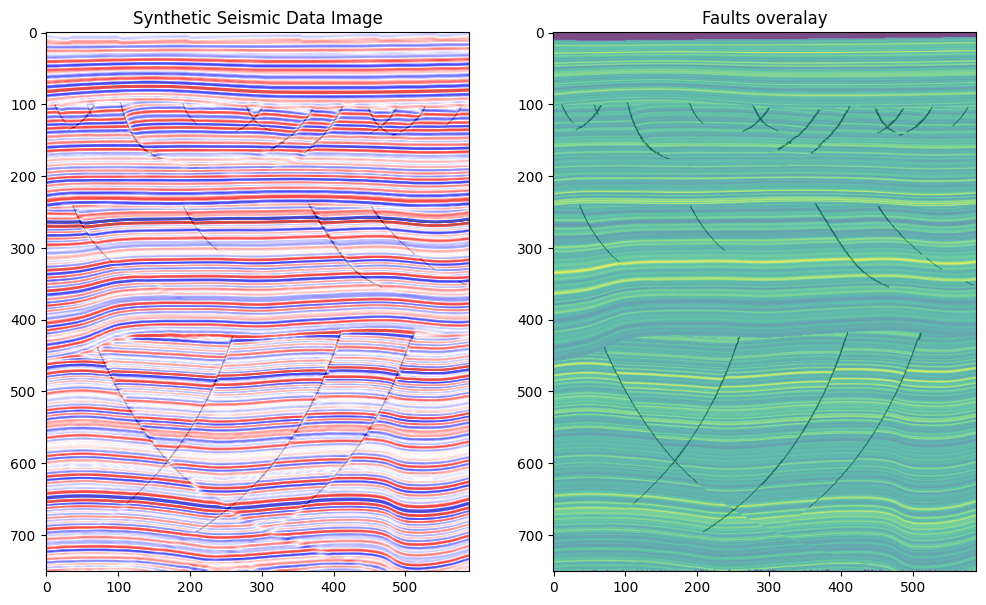

In [59]:
# plot inline
ILINE=10
plt.figure(figsize=(12, 10))
title = ['Synthetic Seismic Data Image', 'Faults overalay']
cmaps = ["seismic", None]

for i, cube in enumerate([seismic, ai]):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(cube[ILINE,:, :].T, cmap=cmaps[i])
    plt.imshow(fault[ILINE,:, :].T, cmap='Greys',  vmin=0, vmax=1, alpha=0.3)
    plt.axis()
plt.show()

### Cropping Input to desired shape

The function provided is used to adjust the shape of the input data by either cropping or padding it so that it becomes a multiple of 32x32 or any other combination of dimensions. The original shape of the artificial data (589x751) was creating issues, so this was a temporary solution to begin conducting some experiments. However, the ultimate goal is to use the actual shape of the data once a suitable solution is found.

In [41]:
def crop_input(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    
    h, w = image.shape[0], image.shape[1]   # values inside the brackets depends on the input shapes
    new_h, new_w = new_shape[0], new_shape[1]
    
    start_h = int((h - new_h + 1)/2)
    start_w = int((w - new_w + 1)/2)
    
    cropped_image = image[start_h:start_h + new_h, start_w:start_w + new_w] 
    
    return cropped_image

# Function to pad 
import torch.nn.functional as F

def pad_to(image, new_shape):
    '''
    Function for padding an image tensor. 
    If somehow the expanding layer output and the skip connection doesn't match,
    these might be helpful.
    '''
    h, w = image.shape[0], image.shape[1]
    new_h, new_w = new_shape[0], new_shape[1]
    
    inc_h, inc_w = new_h -h, new_w - w
    left, right = 0, inc_w
    top, bottom = 0, inc_h
    pads = left, right, top, bottom 
    
    # zero-padding by default.
    # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
    padded_image = F.pad(image, pads, "constant", 0)

    return padded_image

In [55]:
# Some manipulation to get the data into right shape to be input for the UNET++ model.

'''
Previously, We encountered an issue while inputting the data into the network because its current shape was (101, 512, 512). However, the PyTorch implementation requires data in the shape of (m, n, h, w), where m represents the number of samples (in this case, the number of inlines), n represents the number of channels (which is 1 for grayscale or single channel), and h and w are both 512. To overcome this, I concatenated each inline into a list and treated each item on the list as a 2D image. Then, I unsqueezed the list at position (0) to add a 1 dimension, resulting in a shape of (1 x 512 x 512). Finally, I stacked all the items in the list to achieve the desired shape of (101, 1, 512, 512).
'''

'\nPreviously, We encountered an issue while inputting the data into the network because its current shape was (101, 512, 512). However, the PyTorch implementation requires data in the shape of (m, n, h, w), where m represents the number of samples (in this case, the number of inlines), n represents the number of channels (which is 1 for grayscale or single channel), and h and w are both 512. To overcome this, I concatenated each inline into a list and treated each item on the list as a 2D image. Then, I unsqueezed the list at position (0) to add a 1 dimension, resulting in a shape of (1 x 512 x 512). Finally, I stacked all the items in the list to achieve the desired shape of (101, 1, 512, 512).\n'

In [43]:
new_shape = (512, 512)
image_list = []
fault_list = []
for i in range(101):
    images = torch.from_numpy(seismic[i])
    image_list.append(crop_input(images, new_shape ).unsqueeze(0))
    
    faults = torch.from_numpy(fault[i])
    fault_list.append(crop_input(faults, new_shape).unsqueeze(0))

In [44]:
image_list[0].shape

torch.Size([1, 512, 512])

In [45]:
# Loading data into Pytorch Dataset Utitlity
volumes = torch.stack(image_list)
labels = torch.stack(fault_list)
dataset = torch.utils.data.TensorDataset(volumes, labels)

In [46]:
volumes.shape, labels.shape

(torch.Size([101, 1, 512, 512]), torch.Size([101, 1, 512, 512]))

<ipython-input-47-7ef72fe46a8b>:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(volumes[0].T, cmap="gray");


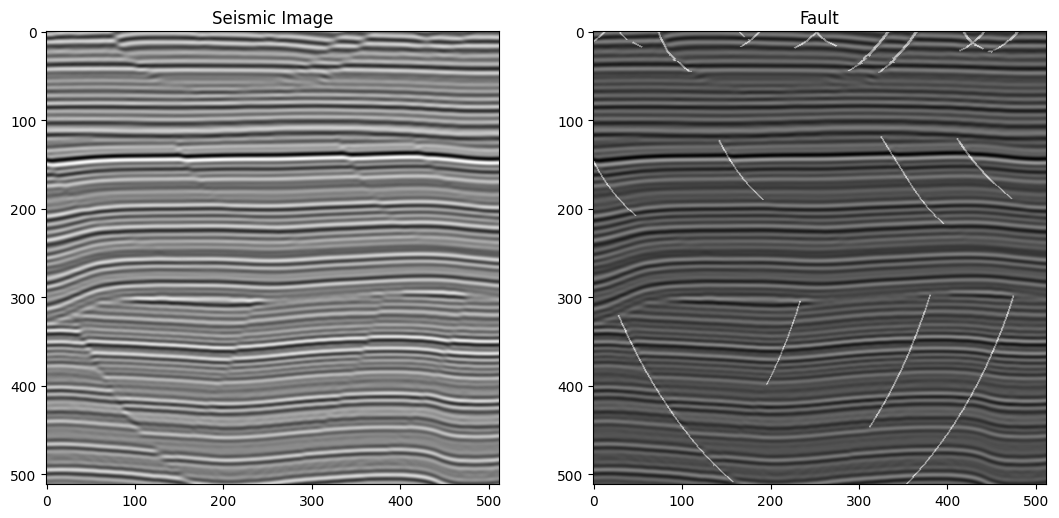

In [47]:
# One last sanity check
fig = plt.figure(figsize=(20,20))
    
ax = fig.add_subplot(331)    
plt.imshow(volumes[0].T, cmap="gray");
ax.set_title("Seismic Image")
    
ax = fig.add_subplot(332)
ax.imshow(volumes[0].T, cmap = 'gray')
ax.imshow(labels[0].T, cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
ax.set_title("Fault")
plt.show();

In [48]:
# Special function to display images side by side after training

def show_tensor_images(image, fault, pred, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_shifted = (image_tensor + 1) / 2
    #image_shifted = image_tensor
    
    image_unflat = image.detach().cpu()
    fault_unflat = fault.detach().cpu()
    pred_unflat = pred.detach().cpu()
    
    
    fig = plt.figure(figsize=(12,15))
    
    ax = fig.add_subplot(331)    
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.set_title("Seismic Image")
    
    ax = fig.add_subplot(332)
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.imshow(fault_unflat.squeeze(), cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Fault")
    
    ax = fig.add_subplot(333)
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.imshow(pred_unflat.squeeze(), cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Predicted Fault")
    
    plt.show()

### Training the Model

* criterion: This refers to the loss function.
* n_epochs: It represents the number of times the entire dataset is iterated during training.
* input_dim: This refers to the number of channels present in the input image.
* label_dim: It represents the number of channels present in the output image.
* display_step: This is the frequency at which images are visualized/displayed.
* batch_size: It refers to the number of images that are processed during each forward/backward pass.
* lr: This is the learning rate.
* initial_shape: The size of the input image in pixels.
* target_shape: The size of the output image in pixels.
* device: It represents the type of device used.


In [49]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [50]:
# Hyperparameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 20    
input_dim = 1
label_dim = 1
display_step = 500
batch_size = 1
lr = 0.0002
initial_shape = 512
target_shape = 512
device = 'cuda'

In [52]:
def train():
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)
    unet = NestedUNet(input_dim, label_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0
    
    train_losses = []

    for epoch in range(n_epochs):
                
        for real, labels in tqdm(dataloader):
            
            cur_batch_size = len(real)
            # Flatten the image
            real = real.to(device)
            labels = labels.to(device)            
                      

            ### Update U-Net ###
            unet_opt.zero_grad()
            pred = unet(real)
            #print(pred.shape)
            unet_loss = criterion(pred, labels)
            unet_loss.backward()
            unet_opt.step()
            

            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                show_tensor_images(real.T.cpu(), labels.T.cpu(), torch.sigmoid(pred).T.cpu(), size=(input_dim, target_shape, target_shape))
            cur_step += 1
        
        train_losses.append(unet_loss)
               
        
    return unet, pred, train_losses


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 0: Step 0: U-Net loss: 0.570214569568634


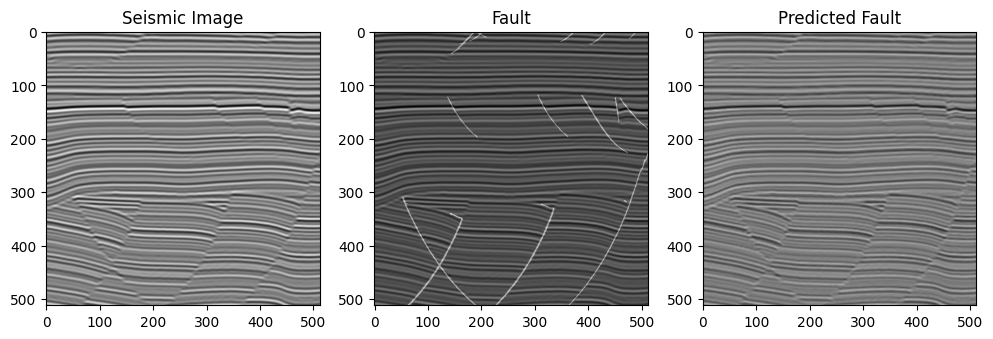

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 4: Step 500: U-Net loss: 0.058486055582761765


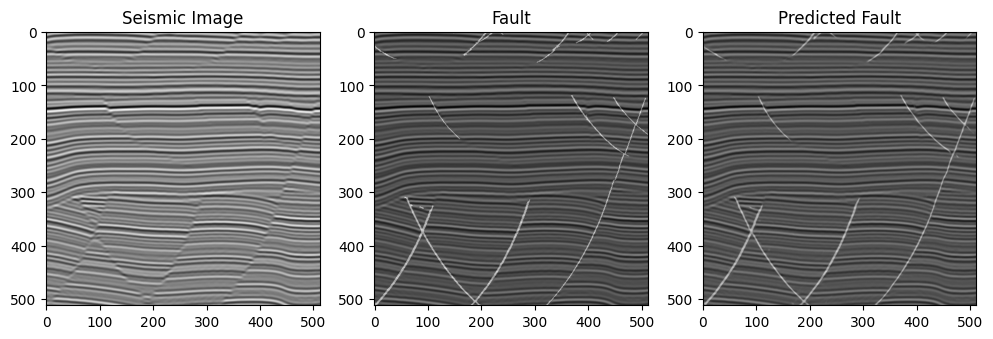

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 9: Step 1000: U-Net loss: 0.023925993591547012


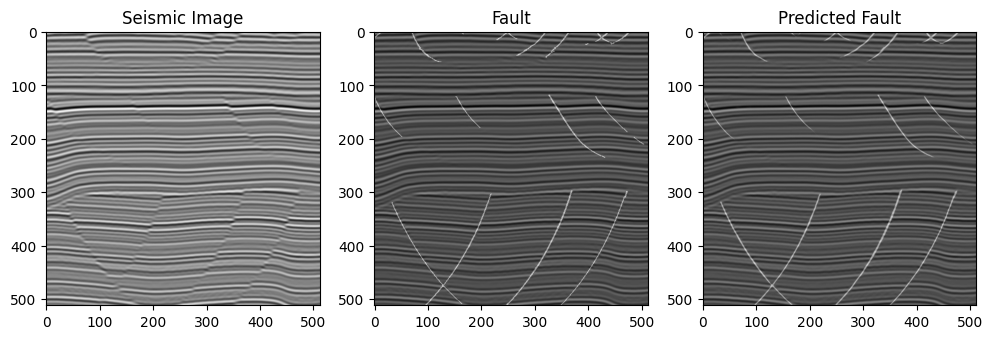

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 14: Step 1500: U-Net loss: 0.012432100251317024


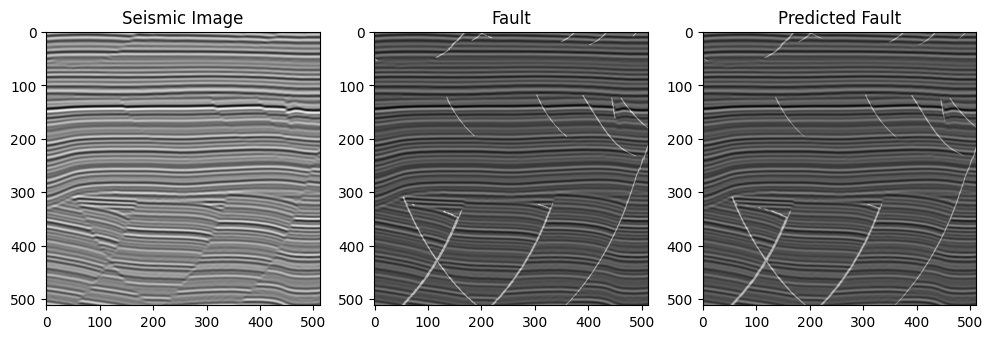

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 19: Step 2000: U-Net loss: 0.007481765933334827


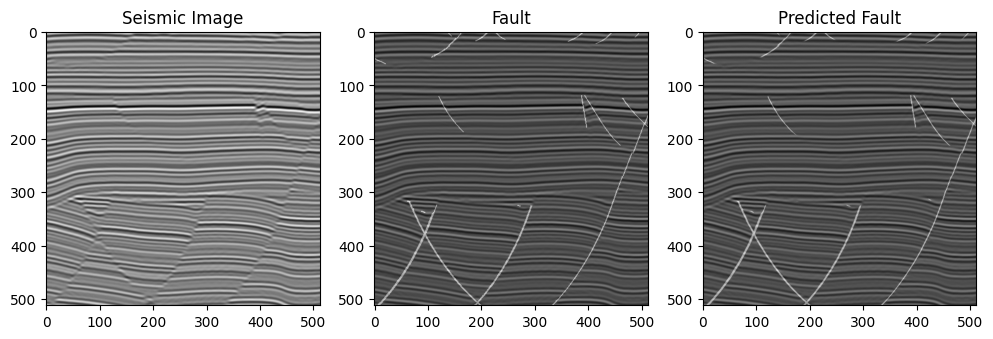

In [53]:
model, pred, loss = train()

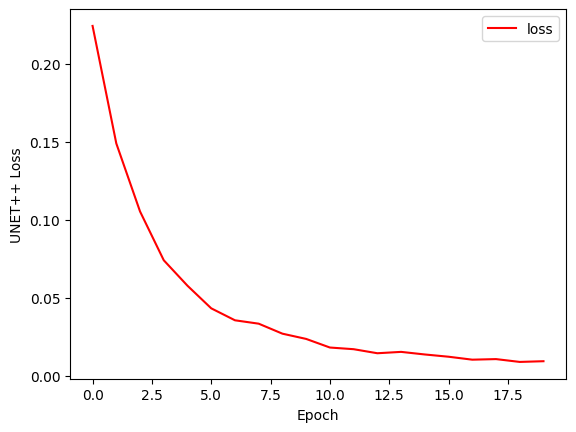

In [56]:
import torch

# Assuming loss is a list of tensors
loss_tensor = torch.stack(loss) # convert list of tensors to a single tensor
plt.plot(loss_tensor.detach().cpu().numpy(), label='loss',color='red')
plt.xlabel('Epoch')
plt.ylabel('UNET++ Loss')
plt.legend()
plt.show()


In [57]:
# Hyperparameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 35    
input_dim = 1
label_dim = 1
display_step = 500
batch_size = 1
lr = 0.0002
initial_shape = 512
target_shape = 512
device = 'cuda'

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 0: Step 0: U-Net loss: 0.5846701860427856


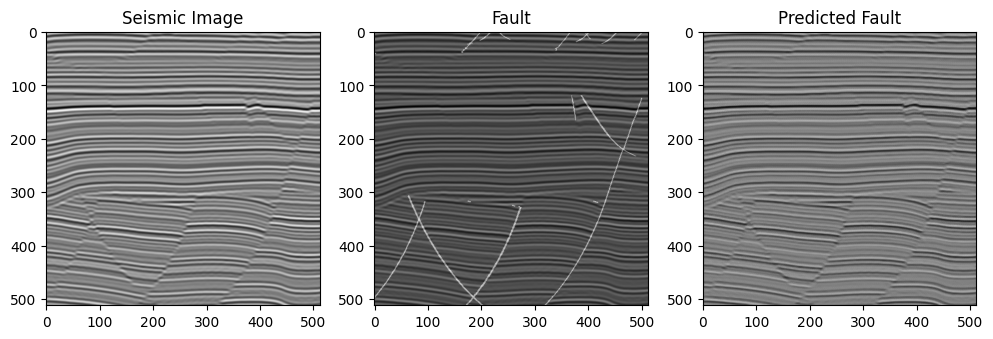

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 4: Step 500: U-Net loss: 0.05843561887741089


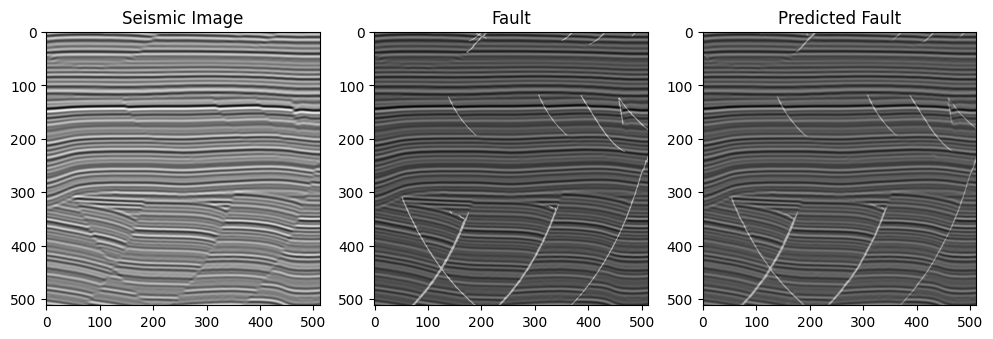

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 9: Step 1000: U-Net loss: 0.022091291844844818


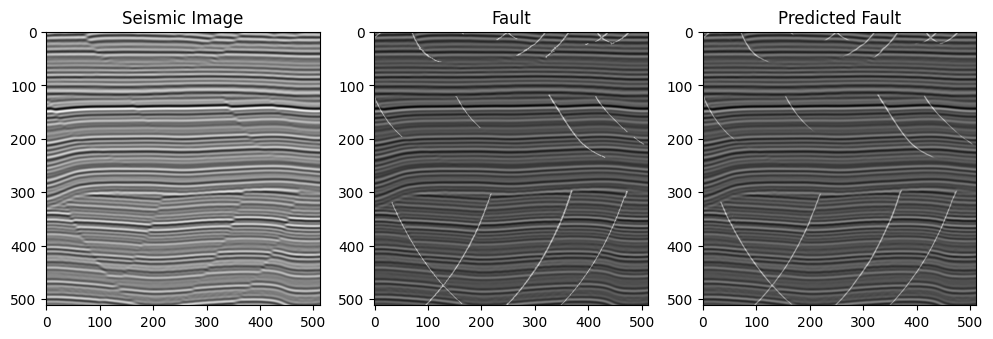

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 14: Step 1500: U-Net loss: 0.012554636225104332


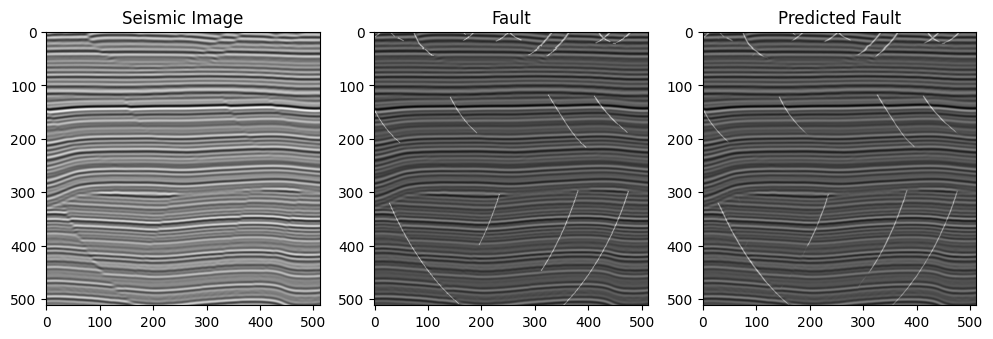

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 19: Step 2000: U-Net loss: 0.01072896458208561


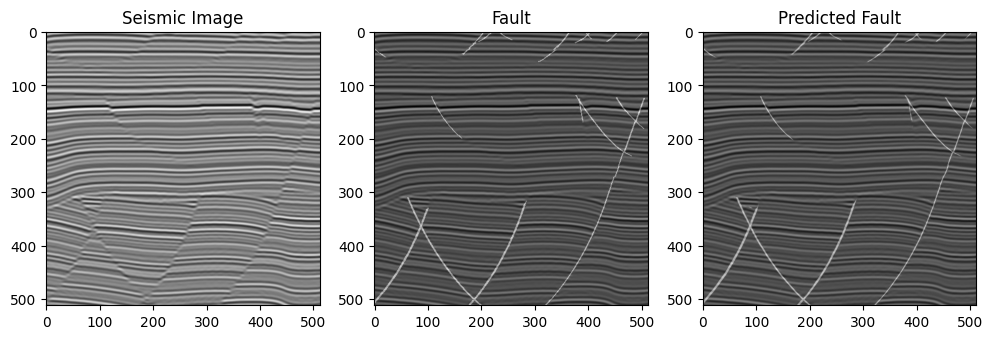

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 24: Step 2500: U-Net loss: 0.0071022952906787395


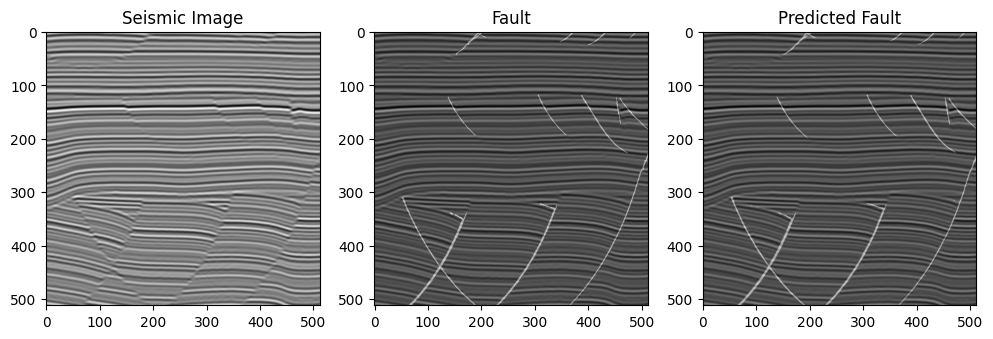

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 29: Step 3000: U-Net loss: 0.00599677162244916


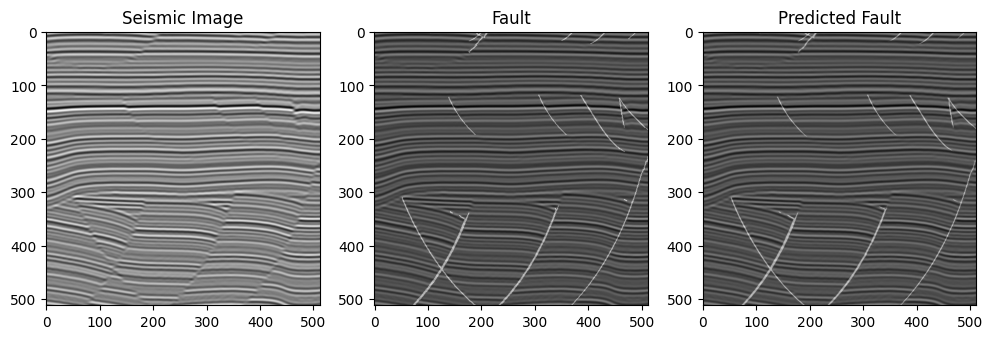

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 34: Step 3500: U-Net loss: 0.006367361173033714


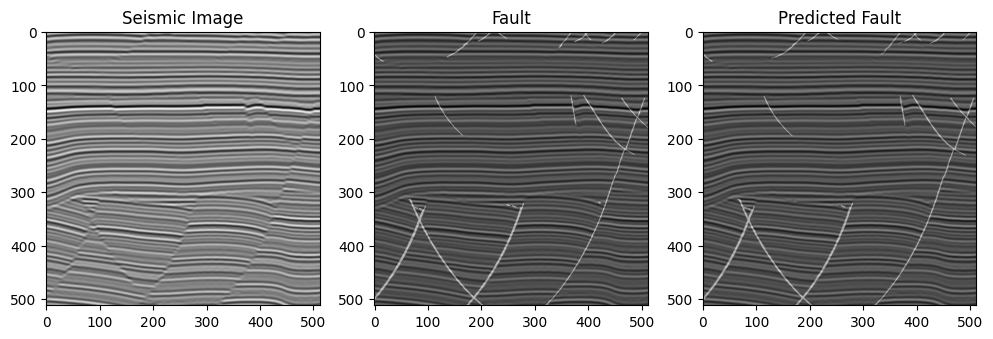

In [58]:
model, pred, loss = train()

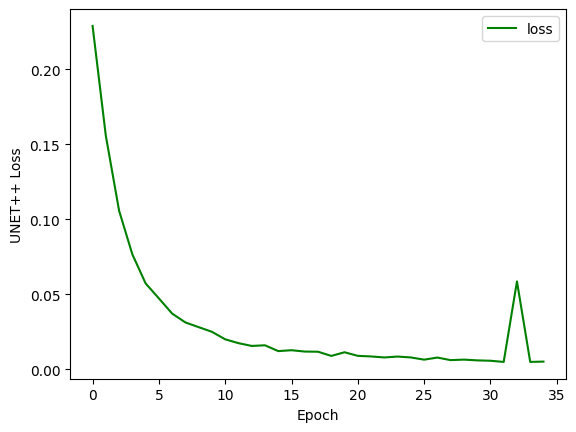

In [60]:
import torch

# Assuming loss is a list of tensors
loss_tensor = torch.stack(loss) # convert list of tensors to a single tensor
plt.plot(loss_tensor.detach().cpu().numpy(), label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('UNET++ Loss')
plt.legend()
plt.show()
